In [1]:
import os
import sys
sys.path.append('../')

from google.cloud import bigquery
from google.oauth2 import service_account

from google.cloud import bigquery
from google.oauth2 import service_account

import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

from authenticate_service_account import main
from utils import *
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import load_model
import SALib as sa
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
import shap


2023-12-03 16:35:35.643623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# client = main()

# query = """
# SELECT *
# FROM skyscanner-insights-343713.Itinerary_Scoring.top_10_ods
# """

# query_job = client.query(query)

# results = query_job.result()


In [3]:
# data = results.to_dataframe()


In [4]:
# data.to_csv('4Mrows.csv', index=False)


In [5]:
data = pd.read_csv('../raw_data/4Mrows.csv')


In [6]:
data.columns


Index(['OriginApt', 'OriginCty', 'OriginCtry', 'DestinationApt',
       'DestinationCty', 'DestinationCtry', 'TravelHorizonDays',
       'TravelDistanceKm', 'SelfTransfer', 'Stops', 'DurationMin',
       'Seg_0_OriginIATA', 'Seg_0_OriginName', 'Seg_0_DestinationIATA',
       'Seg_0_DestinationName', 'Seg_0_OperatingCarrierIATA',
       'Seg_0_TravelDistanceKm', 'Seg_1_OriginIATA', 'Seg_1_OriginName',
       'Seg_1_DestinationIATA', 'Seg_1_DestinationName',
       'Seg_1_OperatingCarrierIATA', 'Seg_1_TravelDistanceKm',
       'Seg_2_OriginIATA', 'Seg_2_OriginName', 'Seg_2_DestinationIATA',
       'Seg_2_DestinationName', 'Seg_2_OperatingCarrierIATA',
       'Seg_2_TravelDistanceKm', 'Seg_3_OriginIATA', 'Seg_3_OriginName',
       'Seg_3_DestinationIATA', 'Seg_3_DestinationName',
       'Seg_3_OperatingCarrierIATA', 'Seg_3_TravelDistanceKm',
       'Seg_0_DurationMin', 'Seg_1_DurationMin', 'Seg_2_DurationMin',
       'Seg_3_DurationMin', 'passengers', 'SearchLowestRatio',
       'ItinLowe

data.dropna(inplace=True)

In [ ]:
model_data.isna().any().any()

## Running preprocessor

In [9]:
processed_data = preprocess(data, raw_od_columns=['OriginCty', 'DestinationCty'], raw_od_ctry=['OriginCtry', 'DestinationCtry'] , as_ratio=True)
processed_data


### Checking the distribution of the target (Score_Z_score_0_50)


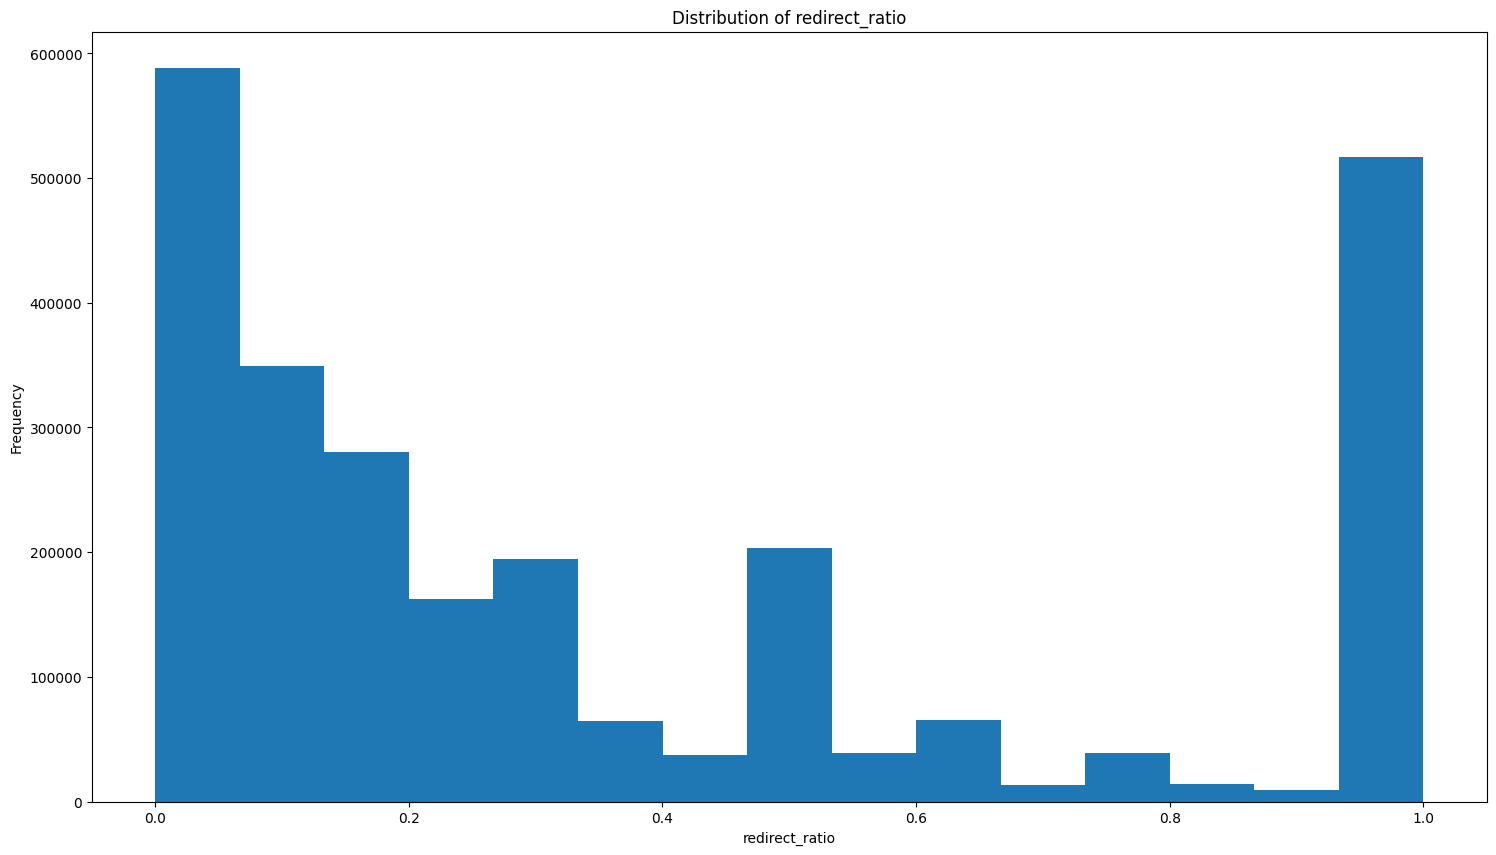

In [ ]:
plt.figure(figsize=(18, 10))
plt.hist(processed_data["Score_Z_score_0_50"], bins=15)
plt.xlabel("Score_Z_score_0_50")
plt.ylabel("Frequency")
plt.title("Distribution of Score_Z_score_0_50")
plt.show()


## Testing the binary encoder

In [ ]:
# import category_encoders as ce
# # Initialize BinaryEncoder
# binary_encoder = ce.BinaryEncoder(cols=["OD"])
# # Fit and transform the data
# binary_encoded_data = binary_encoder.fit_transform(processed_data)
# # Print the result
# print("Binary Encoded data:")
# print(binary_encoded_data.columns)


## Continuing the Pre-Processing

In [ ]:
model_columns = ['TravelDistanceKm', 'TravelHorizonDays', 'SelfTransfer',
                     'total_layover_time_ratio', 'extra_travel_distance_ratio', 'PricePerPax', 'Score_Z_score_0_50']

model_data = processed_data[model_columns]


KeyError: "['Z_Score'] not in index"

In [ ]:
model_data.loc[:, "SelfTransfer"] = model_data["SelfTransfer"].astype(int)


In [ ]:
model_data.head()


,TravelDistanceKm,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax
0,NaN,24,0.50,0,0.141791,NaN,591.81
1,NaN,24,0.50,0,0.198630,NaN,637.90
2,NaN,23,0.25,0,0.000000,NaN,180.11
3,NaN,23,0.25,0,0.000000,NaN,181.19
4,NaN,23,0.25,0,0.000000,NaN,187.10


In [ ]:
model_data.dtypes


TravelDistanceKm               float64
TravelHorizonDays                int64
redirect_ratio                 float64
SelfTransfer                     int64
total_layover_time_ratio       float64
extra_travel_distance_ratio    float64
PricePerPax                    float64
dtype: object

In [ ]:
corr_matrix = model_data.corr()
corr_matrix


,TravelDistanceKm,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax
TravelDistanceKm,1.000000,0.038800,0.054870,0.099576,0.239203,-0.018829,0.706116
TravelHorizonDays,0.038800,1.000000,0.062637,-0.028231,-0.062875,-0.041313,-0.110434
redirect_ratio,0.054870,0.062637,1.000000,0.046109,0.131189,0.064473,0.020449
SelfTransfer,0.099576,-0.028231,0.046109,1.000000,0.435233,0.157274,0.091271
total_layover_time_ratio,0.239203,-0.062875,0.131189,0.435233,1.000000,0.272702,0.202647
extra_travel_distance_ratio,-0.018829,-0.041313,0.064473,0.157274,0.272702,1.000000,0.056644
PricePerPax,0.706116,-0.110434,0.020449,0.091271,0.202647,0.056644,1.000000


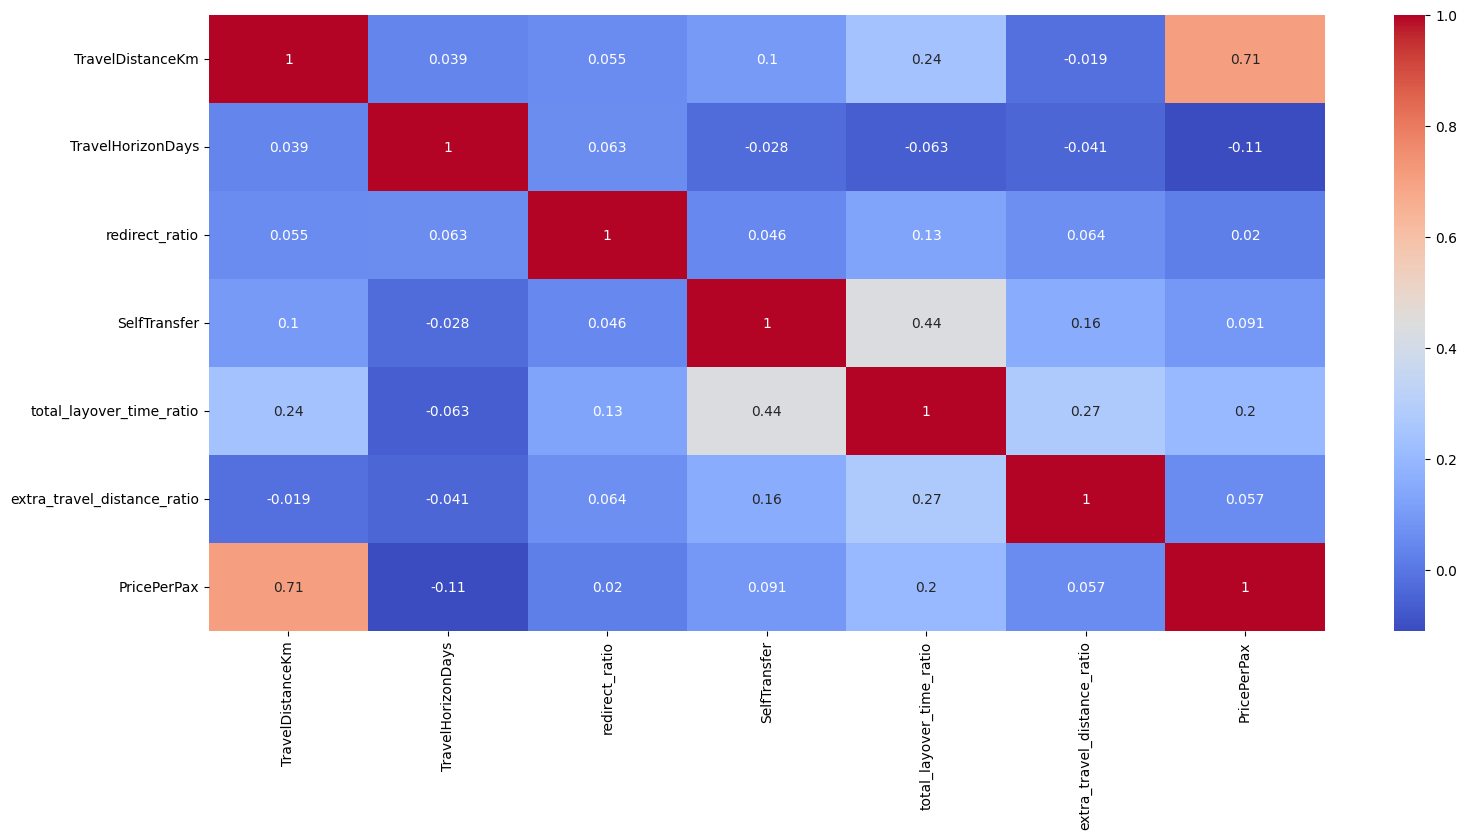

In [ ]:
plt.figure(figsize=(18,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


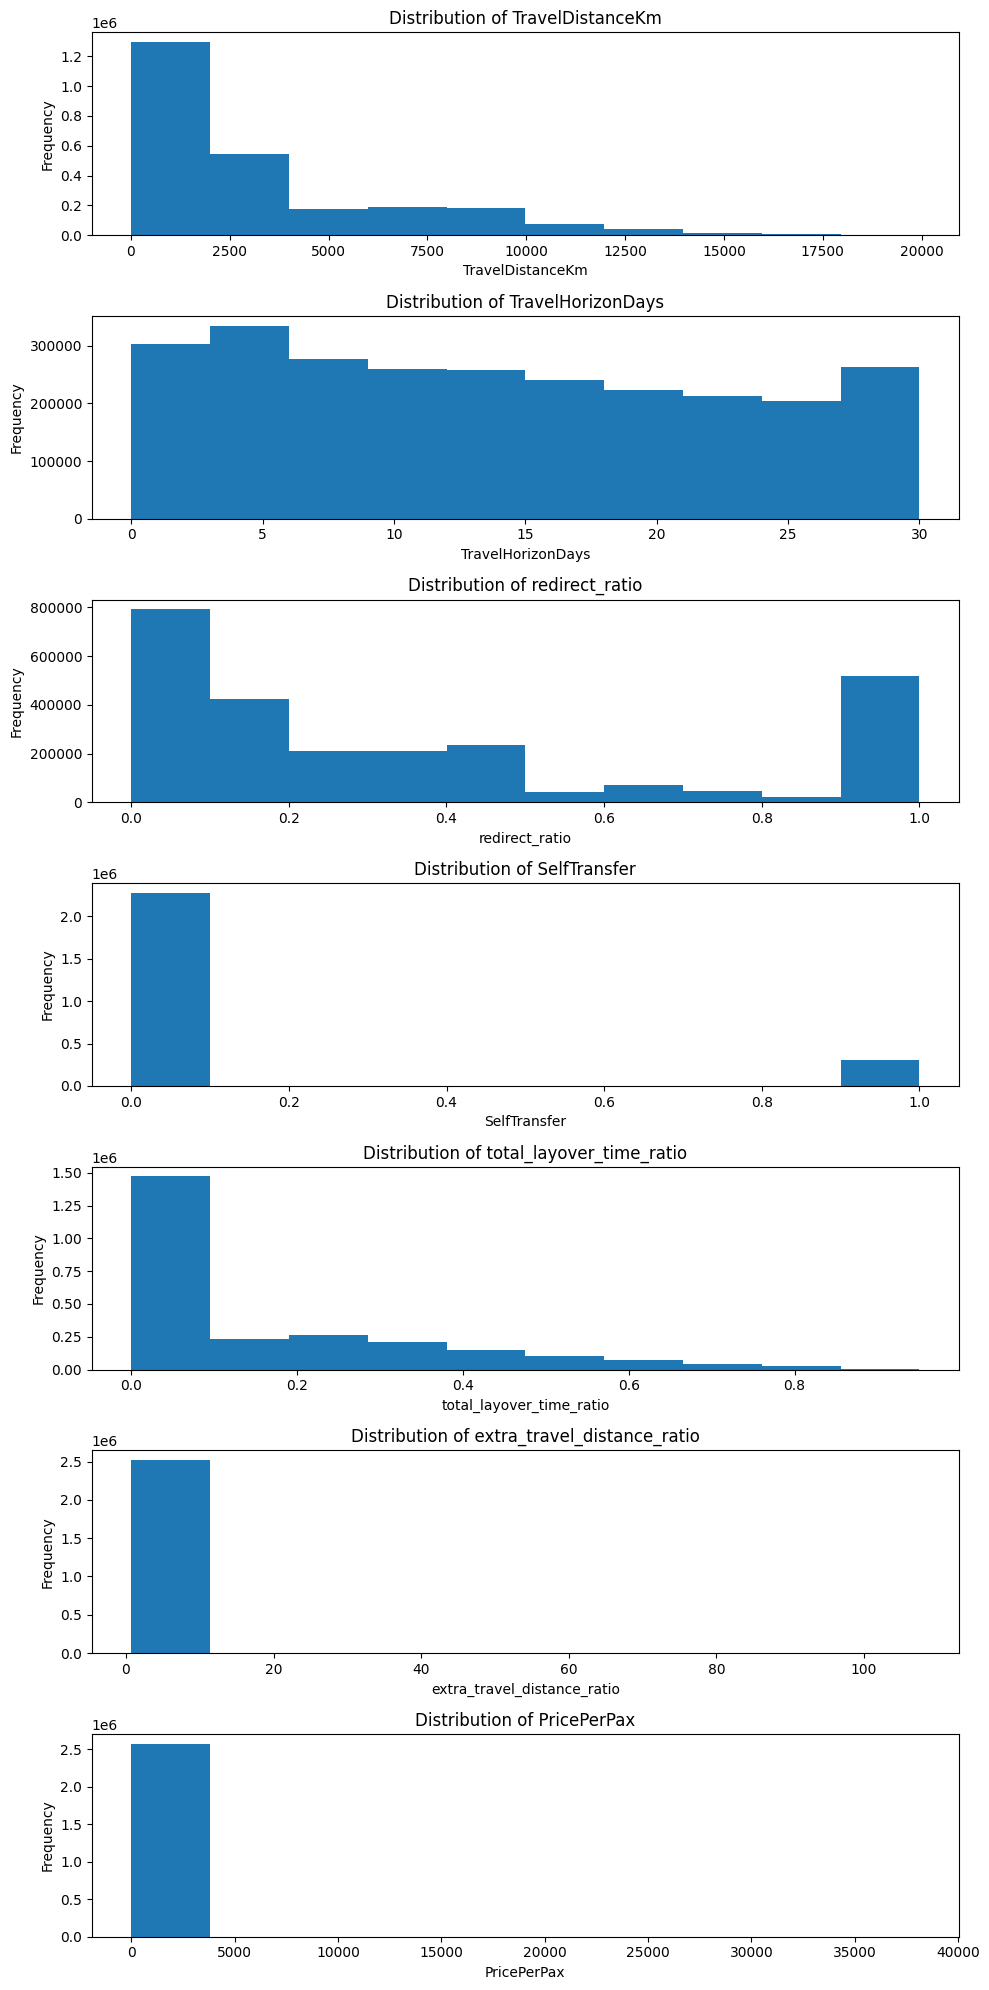

In [ ]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Feature Engineering
- Log of TravelDistanceKm
- Log of redirect_ratio
- Log of total_layover_time
- Log of extra_travel_distance
- Log of PricePerPax

In [ ]:
model_data.head()


,ODRedirects,TravelDistanceKm,TravelHorizonDays,redirect_ratio,SelfTransfer,total_layover_time_ratio,extra_travel_distance_ratio,PricePerPax
0,2,NaN,24,0.50,0,0.141791,NaN,591.81
1,2,NaN,24,0.50,0,0.198630,NaN,637.90
2,4,NaN,23,0.25,0,0.000000,NaN,180.11
3,4,NaN,23,0.25,0,0.000000,NaN,181.19
4,4,NaN,23,0.25,0,0.000000,NaN,187.10


In [ ]:
model_data.loc[:, 'TravelDistanceKm'] = np.log1p(model_data['TravelDistanceKm']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'redirect_ratio'] = np.log1p(model_data['redirect_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'total_layover_time_ratio'] = np.log1p(model_data['total_layover_time_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'extra_travel_distance_ratio'] = np.log1p(model_data['extra_travel_distance_ratio']+ 1e-9)  # 1e-9 is a small constant to offset zero values
model_data.loc[:, 'PricePerPax'] = np.log1p(model_data['PricePerPax']+ 1e-9)  # 1e-9 is a small constant to offset zero values


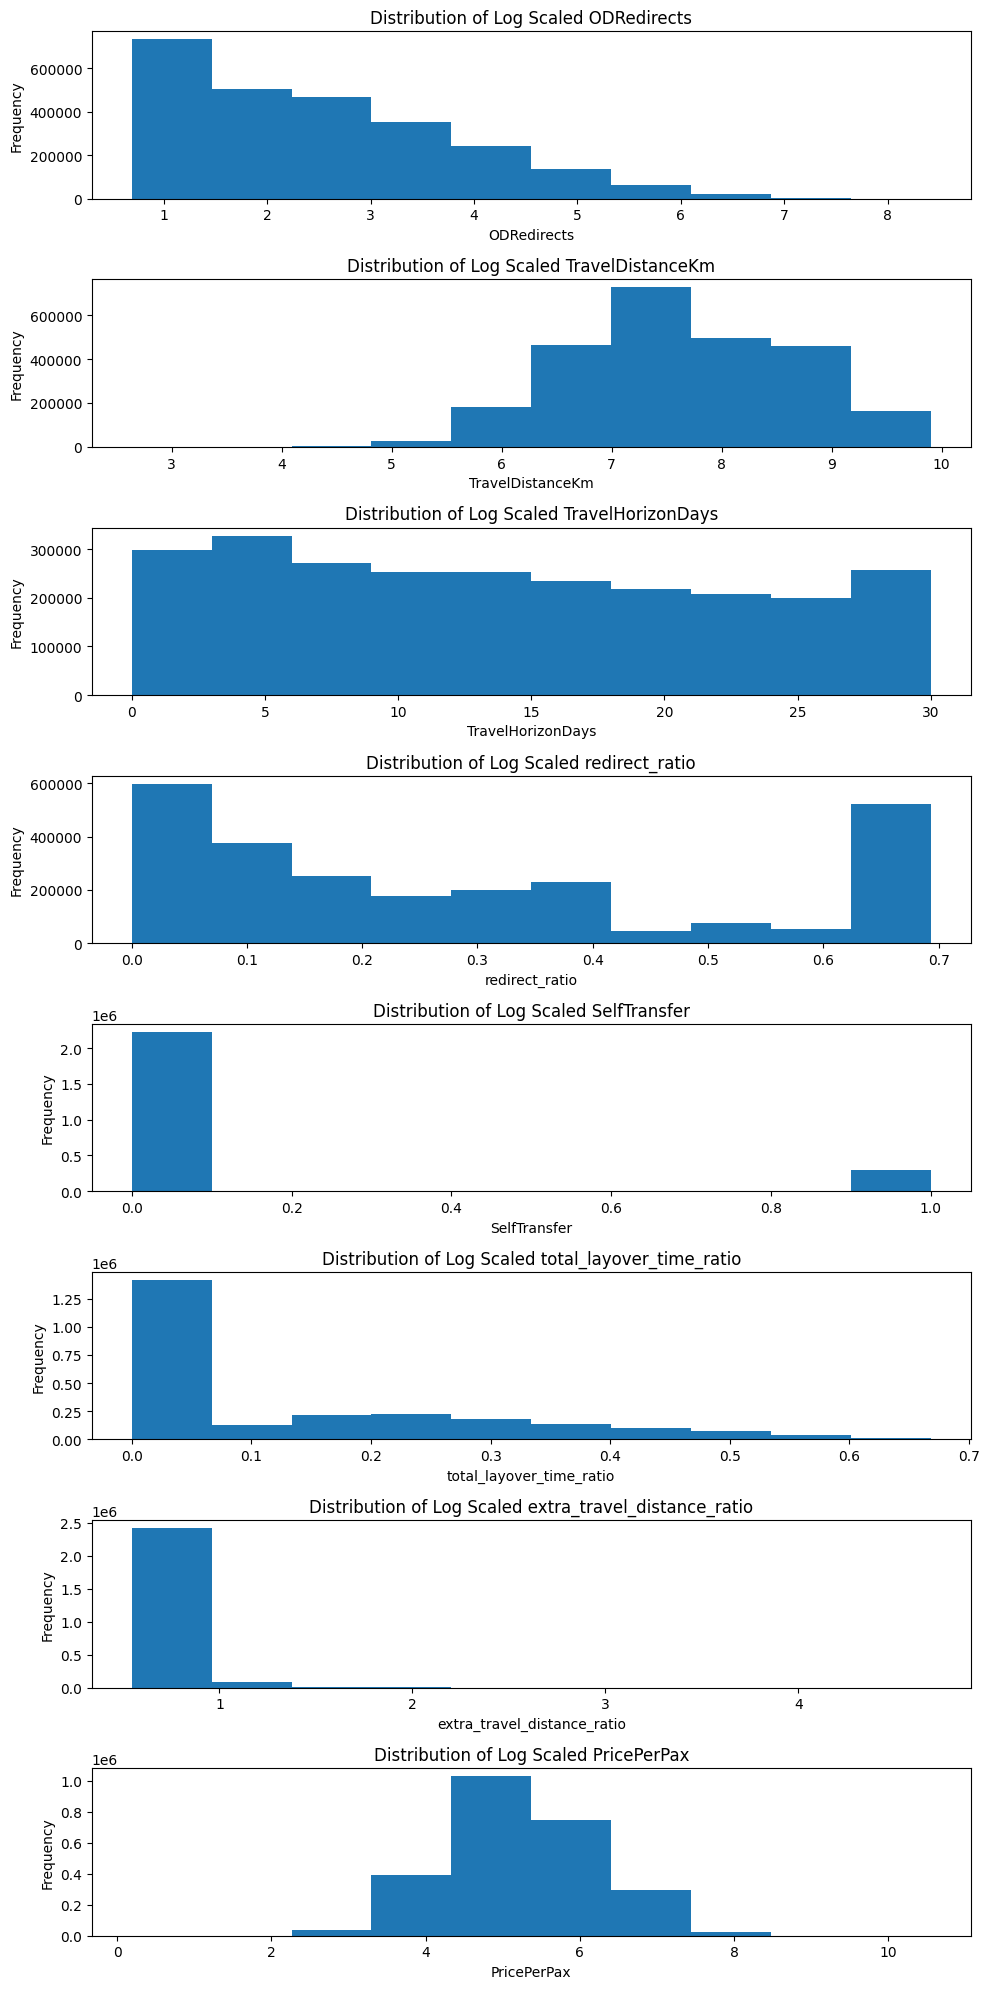

In [ ]:
# Set a larger figure size for readability
plt.figure(figsize=(10, 20))

# Iterate over the columns and create a subplot for each
for i, heading in enumerate(model_data.columns):
    plt.subplot(len(model_data.columns), 1, i+1)
    model_data[heading].plot.hist()
    plt.title(f'Distribution of Log Scaled {heading}')
    plt.xlabel(heading)
    plt.ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Apply MinMax Scalar

In [ ]:
scaler = MinMaxScaler()


In [ ]:
X_train, X_test, y_train, y_test = create_train_test_split(model_data, 'Score_Z_score_0_50')


In [ ]:
# Test_ODRedirect = X_test["ODRedirects"]
# Test_ODRedirect


In [ ]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
model = Sequential()
model.add(layers.Dense(64, input_dim=6, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='linear'))


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                576       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4801 (18.75 KB)
Trainable params: 4801 (18.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=1, mode='min', restore_best_weights=True)


In [29]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])


In [30]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, callbacks=[early_stopping], validation_split=0.2)


Epoch 1/10


ValueError: in user code:

    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/agdoko/.pyenv/versions/3.11.2/envs/OptiFly/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 8), found shape=(None, 7)


In [ ]:
#model.save('my_new_model.h5')


In [ ]:
# model = load_model('../models/my_model.h5')


In [ ]:
# Evaluate the model on the test set
test_loss, test_error = model.evaluate(X_test, y_test, verbose=1)

# Print the results
print(f"Test Loss (MSE): {test_loss}")
print(f"Test Error (MAE): {test_error}")


In [ ]:
y_pred = model.predict(X_test)


15757/15757 [==============================] - 32s 2ms/step


In [ ]:
# X_test.shape


(504217, 7)

In [ ]:
# y_pred.shape


(504217, 1)

In [ ]:
# y_pred.dtype


dtype('float32')

In [ ]:
# y_test.shape


(504217,)

In [ ]:
# y_test.dtypes


dtype('float64')

In [ ]:
y_diff = y_pred.flatten() - y_test


In [ ]:
y_diff_abs = y_diff.abs()


In [ ]:
# y_diff.shape


(504217,)

In [ ]:
# Test_ODRedirect


1010831    7.274480
2080131    1.609438
1283870    2.197225
828039     5.105945
1776132    0.693147
             ...   
2390812    2.484907
1623726    2.484907
1837108    2.484907
926195     1.609438
750779     3.850148
Name: ODRedirects, Length: 504217, dtype: float64

In [ ]:
# Test_ODRedirect = np.expm1(Test_ODRedirect)
# Test_ODRedirect


1010831    1442.0
2080131       4.0
1283870       8.0
828039      164.0
1776132       1.0
            ...  
2390812      11.0
1623726      11.0
1837108      11.0
926195        4.0
750779       46.0
Name: ODRedirects, Length: 504217, dtype: float64

In [ ]:
# plt.figure(figsize=(25, 18))
# plt.scatter(Test_ODRedirect, y_diff, color='blue', alpha=0.1)
# plt.title('Difference in Predictions vs ODRedirects')
# plt.xlabel('ODRedirects')
# plt.ylabel('Prediction Difference (y_pred - y_test)')
# plt.grid(True)


In [ ]:
# plt.figure(figsize=(25, 18))
# plt.scatter(Test_ODRedirect, y_diff_abs, color='blue', alpha=0.1)
# plt.title('Difference in Predictions vs ODRedirects')
# plt.xlabel('ODRedirects')
# plt.ylabel('Abs. Prediction Difference (y_pred - y_test)')
# plt.grid(True)
